# TestCase4 v2 - Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 4
version = 4
assert version in [2, 3, 4, 5]
param_num = 1

**Idée :** On se place ici dans le TestCase3.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.utils import create_tree

from modules.geometry import Donut
from modules.fenics_expressions import FExpr,UexExpr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [4]:
if testcase == 4:
    if version == 2:
        from modules.testcases.d2.test_4.test_4_v2 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut import FEMSolver
    elif version == 3:
        from modules.testcases.d2.test_4.test_4_v3 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut import FEMSolver
    elif version == 4:
        from modules.testcases.d2.test_4.test_4_v4 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut_v4 import FEMSolver
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase4
    problem = TestCase4(v=version)
else:
    raise ValueError("Testcase not found")

result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

torch loaded; device is cuda


>> load network /home/flecourtier/Bureau/Article1/code/networks/test_fe4_v4.pth
jsbdbshd
network loaded


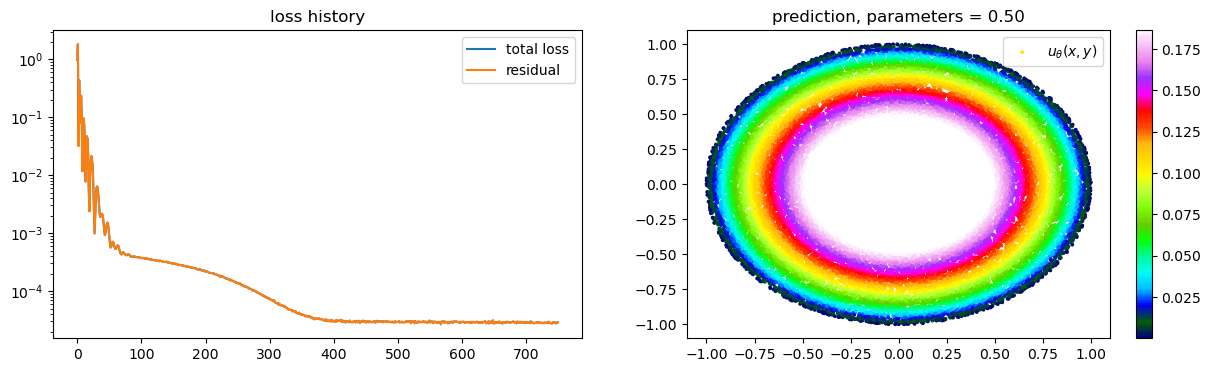

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    parameter_domain = problem.parameter_domain
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.5]


## Convergence FEM

In [8]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

hmax =  0.16663035129479017
nb_vert=16, norme_L2=2.800102020400261e-07
nb_vert=16, norme_L2=1.0283551758729669e-06
hmax =  0.08691933730437637
nb_vert=32, norme_L2=1.9677096453045858e-08
nb_vert=32, norme_L2=6.664205208503004e-08
hmax =  0.04347038548979546
nb_vert=64, norme_L2=1.1024682195155153e-09
nb_vert=64, norme_L2=3.695798395465203e-09


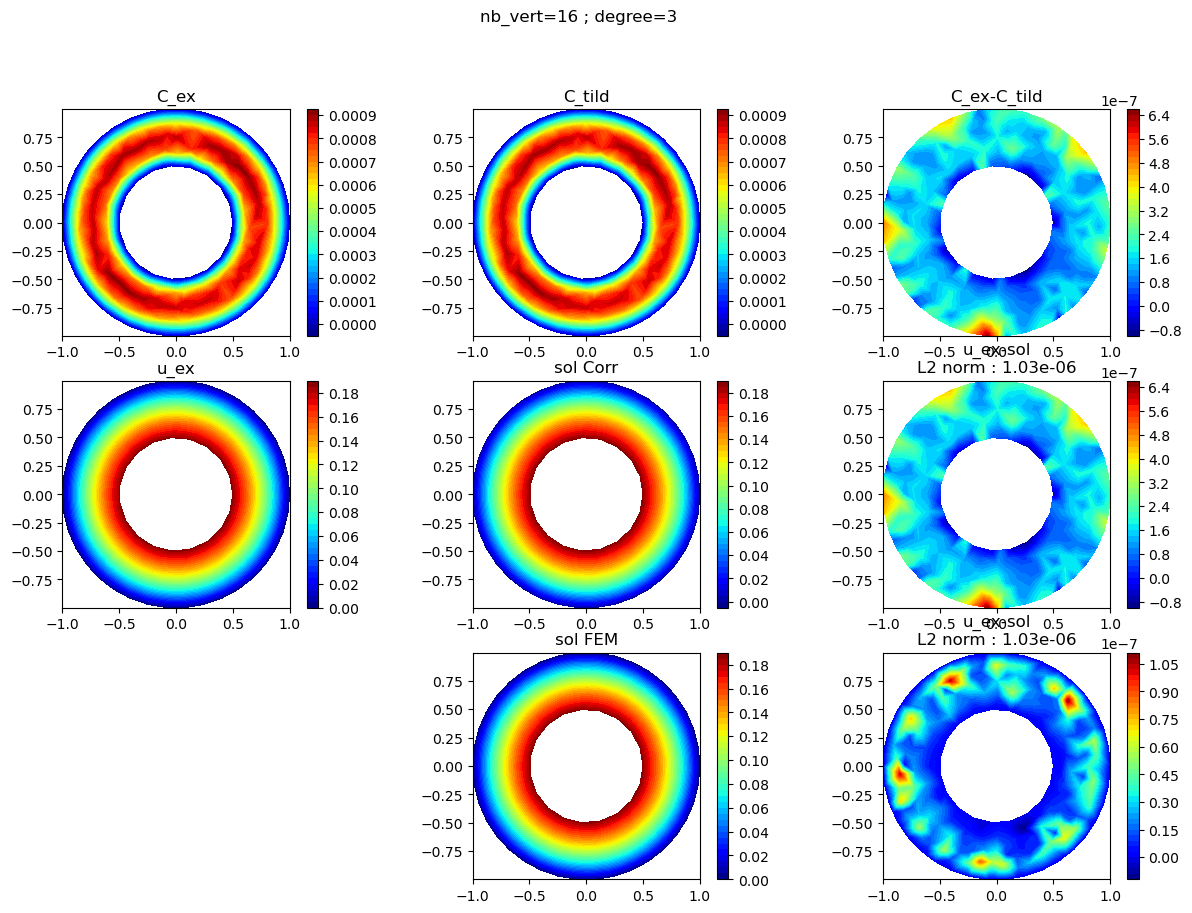

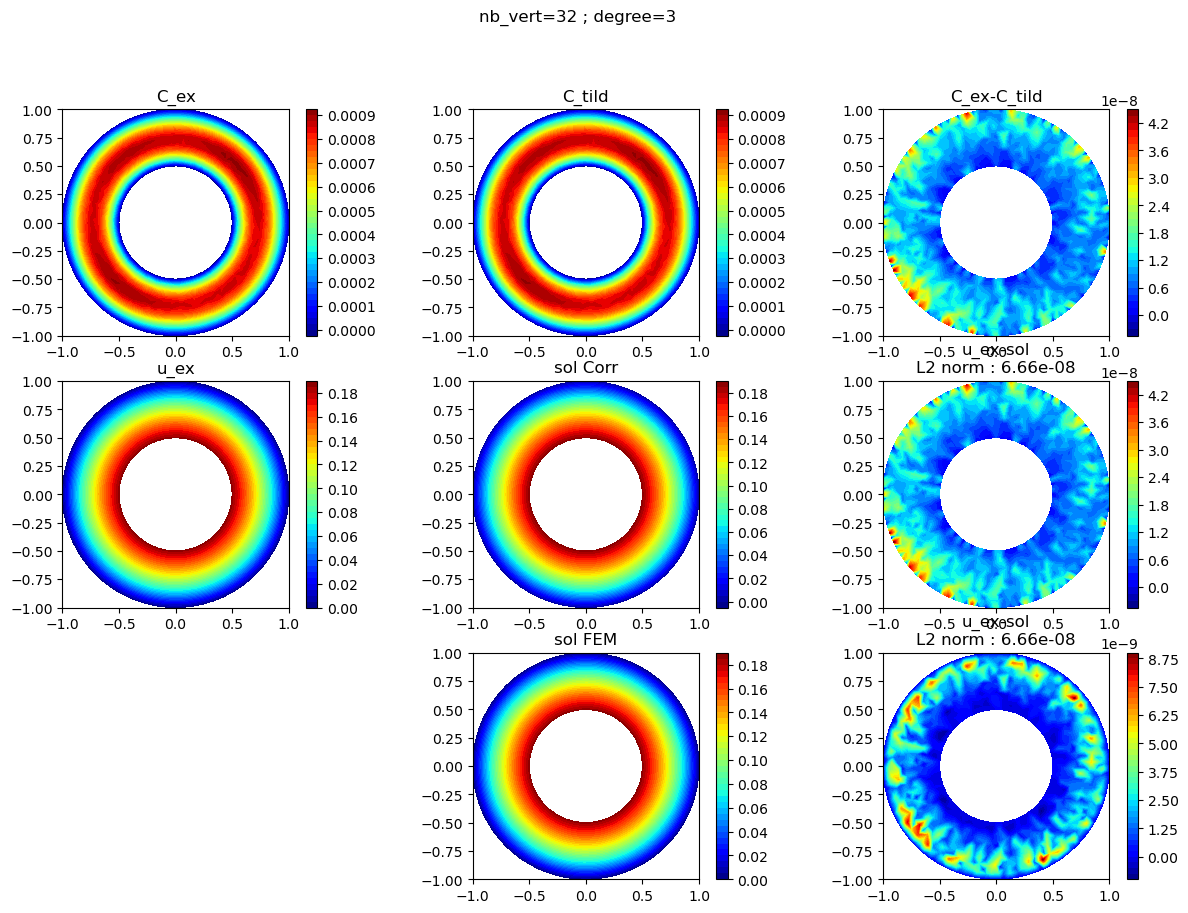

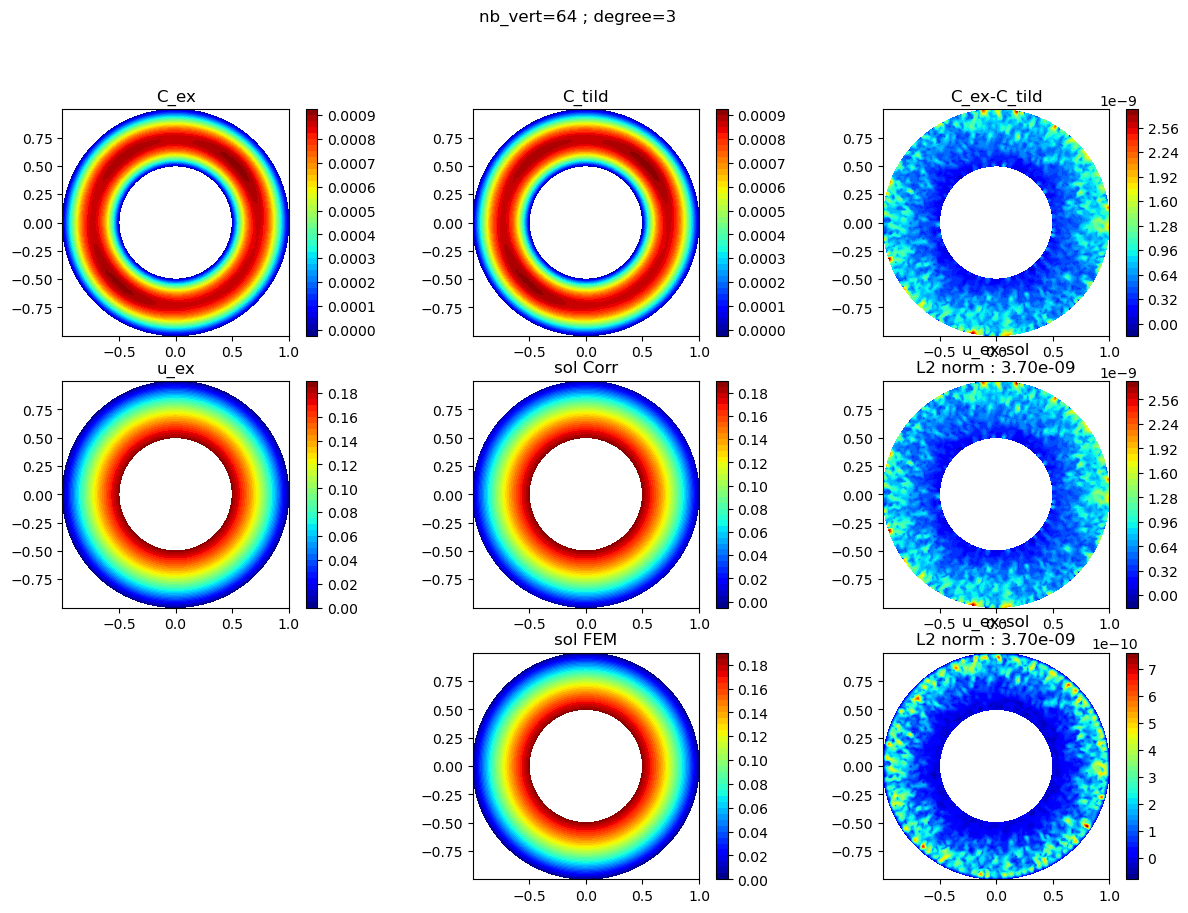

In [11]:
tab_nb_vert_FEM = [16,32,64]
degree = 3
degree_PINNs = 10

for nb_vert in tab_nb_vert_FEM:
    solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
    u_ref = UexExpr(param, degree=10, domain=solver.mesh, pb_considered=problem)
    
    # FEM
    sol_FEM,norme_L2_FEM = solver.fem(0)
    print(f"nb_vert={nb_vert}, norme_L2={norme_L2_FEM}")

    # Corr
    V_test,X_test,mu_test = get_test_sample(0,solver,trainer,degree_PINNs)
    pred = u_theta.setup_w_dict(X_test, mu_test)
    phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
    u_PINNs = df.Function(V_test)
    u_PINNs.vector()[:] = phi_tild.copy()
            
    # uref_Vex = interpolate(u_ref,solver.V_ex)
    # sol_Vex = interpolate(u_PINNs,solver.V_ex)
    # norme_L2_PINNs = (assemble((((uref_Vex - sol_Vex)) ** 2) * solver.dx) ** (0.5)) / (assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))

    # print(f"nb_vert={nb_vert}, norme_L2_PINNs={norme_L2_PINNs}")
    
    sol,C_tild,norme_L2_Corr = solver.corr_add(0,u_PINNs,nonexactBC=False)

    print(f"nb_vert={nb_vert}, norme_L2={norme_L2_Corr}")
    
    ### PLOTT
    colormap = "jet"

    V_test_,X_test_,mu_test_ = get_test_sample(0,solver,trainer,degree)
    pred = u_theta.setup_w_dict(X_test_, mu_test_)
    phi_tild = pred["w"][:,0].cpu().detach().numpy()

    u_PINNs_1 = df.Function(solver.V)
    u_PINNs_1.vector()[:] = phi_tild.copy()

    C_ex = df.Function(solver.V)
    u_ref_inter = df.interpolate(u_ref,solver.V)
    C_ex.vector()[:] = u_ref_inter.vector()[:] - u_PINNs_1.vector()[:]

    plt.figure(figsize=(15,10))

    plt.subplot(3,3,1)
    c = df.plot(C_ex,cmap=colormap)
    plt.colorbar(c)
    plt.title("C_ex")

    plt.subplot(3,3,2)
    c = df.plot(C_tild,cmap=colormap)
    plt.colorbar(c)
    plt.title("C_tild")

    plt.subplot(3,3,3)
    error = df.Function(solver.V)
    error.vector()[:] = C_ex.vector()[:] - C_tild.vector()[:]
    c = df.plot(error,cmap=colormap)
    plt.colorbar(c)
    plt.title("C_ex-C_tild")

    plt.subplot(3,3,4)
    c = df.plot(u_ref_inter,cmap=colormap)
    plt.colorbar(c)
    plt.title("u_ex")

    plt.subplot(3,3,5)
    # sol_inter = df.project(sol,solver.V)
    sol_inter = df.Function(solver.V)
    sol_inter.vector()[:] = u_PINNs_1.vector()[:] + C_tild.vector()[:]
    c = df.plot(sol_inter,cmap=colormap)
    plt.colorbar(c)
    plt.title("sol Corr")

    plt.subplot(3,3,6)
    error = df.Function(solver.V)
    error.vector()[:] = u_ref_inter.vector()[:] - sol_inter.vector()[:]
    c = df.plot(error,cmap=colormap)
    plt.colorbar(c)
    plt.title(f"u_ex-sol\nL2 norm : {norme_L2_Corr:.2e}")
    
    # FEM
    plt.subplot(3,3,8)
    sol_inter = df.interpolate(sol_FEM,solver.V)
    c = df.plot(sol_inter,cmap=colormap)
    plt.colorbar(c)
    plt.title("sol FEM")

    plt.subplot(3,3,9)
    error = df.Function(solver.V)
    error.vector()[:] = u_ref_inter.vector()[:] - sol_inter.vector()[:]
    c = df.plot(error,cmap=colormap)
    plt.colorbar(c)
    plt.title(f"u_ex-sol\nL2 norm : {norme_L2_Corr:.2e}")    

    plt.suptitle(f"nb_vert={nb_vert} ; degree={degree}")

    plt.savefig(result_dir+f'plotcorr_case{testcase}_v{version}_N{nb_vert}_degree{degree}.png')